In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd

In [3]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Regression</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [9]:
def filter_svr_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_momentum_type' in cv_results.columns:
        filtered_cv_results['momentum'] = cv_results['param_momentum_type']
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly')
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf')
    
    filtered_cv_results[['C', 'epsilon', 'fit_time', 
                         'train_r2', 'val_r2']] = cv_results[['param_C', 'param_epsilon', 'mean_fit_time', 
                                                              'mean_train_r2', 'mean_test_r2']]
    
    if 'mean_train_n_iter' in cv_results.columns:
        filtered_cv_results['n_iter'] = cv_results['mean_train_n_iter'].round().astype(int)
    
    filtered_cv_results['train_n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)
    filtered_cv_results['val_n_sv'] = cv_results['mean_test_n_sv'].round().astype(int)

    return filtered_cv_results

## Epsilon-insensitive loss

### Primal formulation

In [4]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.datasets import make_regression
from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [6]:
def primal_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.iter, 
            'n_sv': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


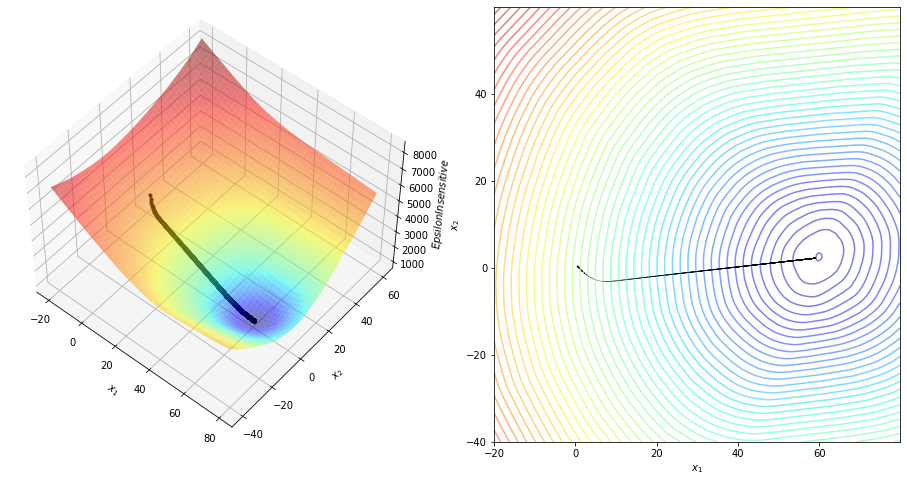

In [7]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, optimizer=AdaGrad, learning_rate=1, 
                              max_iter=4000, early_stopping=True, patience=5),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-20, x_max=80, y_min=-40, y_max=60)
plt.savefig('./tex/img/svr_eps_loss.png')

In [10]:
custom_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svr_eps_cv_results.insert(0, 'solver', 'adagrad')
custom_primal_svr_eps_cv_results.style.hide_index()

solver,C,epsilon,fit_time,train_r2,val_r2,n_iter,train_n_sv,val_n_sv
adagrad,1,0.100000,0.561802,0.919198,0.915683,869,66,33
adagrad,1,0.200000,0.551649,0.919997,0.916509,881,66,33
adagrad,1,0.300000,0.527632,0.920133,0.916705,893,65,33
adagrad,10,0.100000,2.012761,0.977833,0.972862,3542,65,32
adagrad,10,0.200000,1.977470,0.977798,0.972835,3535,65,32
adagrad,10,0.300000,1.973998,0.977779,0.972874,3457,65,32
adagrad,100,0.100000,2.309597,0.978118,0.974218,3999,66,32
adagrad,100,0.200000,2.314033,0.978120,0.974217,3999,66,32
adagrad,100,0.300000,1.945511,0.978120,0.974178,3999,66,32


In [11]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(SkLinearSVR(loss='epsilon_insensitive'),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [12]:
liblinear_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svr_eps_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svr_eps_cv_results.style.hide_index()

solver,C,epsilon,fit_time,train_r2,val_r2,n_iter,train_n_sv,val_n_sv
liblinear,1,0.100000,0.000810,0.918567,0.916697,7,65,33
liblinear,1,0.200000,0.000594,0.918766,0.916605,13,65,32
liblinear,1,0.300000,0.000564,0.919173,0.916936,12,65,32
liblinear,10,0.100000,0.000709,0.977852,0.972053,94,64,33
liblinear,10,0.200000,0.000545,0.977851,0.972026,120,65,33
liblinear,10,0.300000,0.000637,0.977870,0.972136,127,64,33
liblinear,100,0.100000,0.000992,0.977723,0.974271,675,65,33
liblinear,100,0.200000,0.000990,0.977673,0.974129,735,65,33
liblinear,100,0.300000,0.001365,0.977658,0.974012,800,66,33


In [13]:
primal_svr_eps_cv_results = custom_primal_svr_eps_cv_results.append(liblinear_primal_svr_eps_cv_results, ignore_index=True)
primal_svr_eps_cv_results.sort_values(['epsilon', 'C', 'solver'], inplace=True)
primal_svr_eps_cv_results.to_latex('./tex/experiments/primal_svr_eps.tex', index=False)
primal_svr_eps_cv_results.style.hide_index()

solver,C,epsilon,fit_time,train_r2,val_r2,n_iter,train_n_sv,val_n_sv
adagrad,1,0.100000,0.561802,0.919198,0.915683,869,66,33
liblinear,1,0.100000,0.000810,0.918567,0.916697,7,65,33
adagrad,10,0.100000,2.012761,0.977833,0.972862,3542,65,32
liblinear,10,0.100000,0.000709,0.977852,0.972053,94,64,33
adagrad,100,0.100000,2.309597,0.978118,0.974218,3999,66,32
liblinear,100,0.100000,0.000992,0.977723,0.974271,675,65,33
adagrad,1,0.200000,0.551649,0.919997,0.916509,881,66,33
liblinear,1,0.200000,0.000594,0.918766,0.916605,13,65,32
adagrad,10,0.200000,1.977470,0.977798,0.972835,3535,65,32
liblinear,10,0.200000,0.000545,0.977851,0.972026,120,65,33


### Dual formulations

In [14]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel
from optiml.ml.utils import generate_nonlinearly_regression_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [15]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT


class SklSVR(SVR):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super().fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])

In [16]:
def dual_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SVR) else (0 if isinstance(svr.optimizer, str)
                                                                else svr.optimizer.iter), 
            'n_sv': len(svr.support_)}

#### Wolfe Dual

##### Linear

Fitting 3 folds for each of 18 candidates, totalling 54 fits


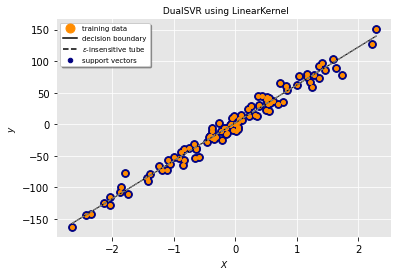

In [17]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(DualSVR(kernel=linear),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/linear_dual_svr_hyperplane.png')

In [18]:
custom_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svr_cv_results['n_iter'].replace(0, '-', inplace=True)
custom_linear_dual_svr_cv_results.style.hide_index()

solver,C,epsilon,fit_time,train_r2,val_r2,n_iter,train_n_sv,val_n_sv
smo,1,0.100000,0.014242,0.917773,0.914442,14,66,66
cvxopt,1,0.100000,0.015898,0.917772,0.914479,-,67,67
smo,1,0.200000,0.012662,0.918341,0.915019,12,66,66
cvxopt,1,0.200000,0.020107,0.918341,0.915058,-,67,67
smo,1,0.300000,0.038214,0.918942,0.915576,59,66,66
cvxopt,1,0.300000,0.018228,0.918942,0.915614,-,66,66
smo,10,0.100000,0.071679,0.977920,0.972445,55,66,66
cvxopt,10,0.100000,0.016083,0.977920,0.972466,-,67,67
smo,10,0.200000,0.169674,0.977926,0.972457,218,65,65
cvxopt,10,0.200000,0.016285,0.977926,0.972474,-,67,67


In [19]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(SklSVR(kernel='linear', verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[LibSVM]

In [20]:
libsvm_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_svr_cv_results.style.hide_index()

solver,C,epsilon,fit_time,train_r2,val_r2,n_iter,train_n_sv,val_n_sv
libsvm,1,0.100000,0.003156,0.917627,0.915448,63,66,66
libsvm,1,0.200000,0.004471,0.918194,0.915985,102,66,66
libsvm,1,0.300000,0.002892,0.918786,0.916554,54,66,66
libsvm,10,0.100000,0.002189,0.977852,0.972051,282,66,66
libsvm,10,0.200000,0.006612,0.977851,0.972025,193,65,65
libsvm,10,0.300000,0.005697,0.977870,0.972135,593,65,65
libsvm,100,0.100000,0.004521,0.977723,0.974270,2621,66,66
libsvm,100,0.200000,0.004417,0.977673,0.974122,2709,66,66
libsvm,100,0.300000,0.003464,0.977655,0.974045,4141,66,66


In [21]:
linear_dual_svr_cv_results = custom_linear_dual_svr_cv_results.append(libsvm_linear_dual_svr_cv_results, ignore_index=True)
linear_dual_svr_cv_results.sort_values(['epsilon', 'C', 'solver'], inplace=True)
linear_dual_svr_cv_results.to_latex('./tex/experiments/linear_dual_svr.tex', index=False)
linear_dual_svr_cv_results.style.hide_index()

solver,C,epsilon,fit_time,train_r2,val_r2,n_iter,train_n_sv,val_n_sv
cvxopt,1,0.100000,0.015898,0.917772,0.914479,-,67,67
libsvm,1,0.100000,0.003156,0.917627,0.915448,63,66,66
smo,1,0.100000,0.014242,0.917773,0.914442,14,66,66
cvxopt,10,0.100000,0.016083,0.977920,0.972466,-,67,67
libsvm,10,0.100000,0.002189,0.977852,0.972051,282,66,66
smo,10,0.100000,0.071679,0.977920,0.972445,55,66,66
cvxopt,100,0.100000,0.012125,0.977788,0.974150,-,67,67
libsvm,100,0.100000,0.004521,0.977723,0.974270,2621,66,66
smo,100,0.100000,0.569793,0.977788,0.974139,1507,66,66
cvxopt,1,0.200000,0.020107,0.918341,0.915058,-,67,67


##### Nonlinear

Fitting 3 folds for each of 18 candidates, totalling 54 fits


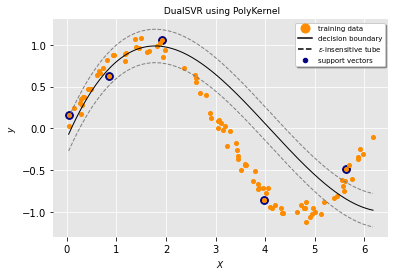

In [22]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(DualSVR(),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/poly_dual_svr_hyperplane.png')

In [23]:
poly_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_svr_cv_results['n_iter'].replace(0, '-', inplace=True)
poly_nonlinear_dual_svr_cv_results.style.hide_index()

solver,kernel,C,epsilon,fit_time,train_r2,val_r2,n_iter,train_n_sv,val_n_sv
smo,poly,1,0.100000,52.024504,0.309358,-30.592107,101185,18,18
cvxopt,poly,1,0.100000,0.012785,0.414638,-26.864749,-,18,18
smo,poly,1,0.200000,1.905395,-78.501086,-28.105470,2702,6,6
cvxopt,poly,1,0.200000,0.019310,-24.725734,-14.560019,-,5,5
smo,poly,1,0.300000,0.359517,-4.782670,-73.217161,571,4,4
cvxopt,poly,1,0.300000,0.010673,-2.454608,-71.364588,-,4,4
smo,poly,10,0.100000,732.300189,0.506437,-42.271049,1596205,18,18
cvxopt,poly,10,0.100000,0.010302,0.756741,-37.096432,-,19,19
smo,poly,10,0.200000,3.858863,-5.246133,-24.474814,5490,4,4
cvxopt,poly,10,0.200000,0.011569,-1.399837,-13.286394,-,4,4


Fitting 3 folds for each of 18 candidates, totalling 54 fits


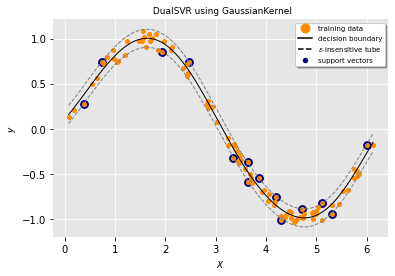

In [24]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(DualSVR(),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/gaussian_dual_svr_hyperplane.png')

In [25]:
rbf_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_svr_cv_results['n_iter'].replace(0, '-', inplace=True)
rbf_nonlinear_dual_svr_cv_results.style.hide_index()

solver,kernel,C,epsilon,fit_time,train_r2,val_r2,n_iter,train_n_sv,val_n_sv
smo,rbf,1,0.100000,0.030710,0.975638,-2.110523,27,11,11
cvxopt,rbf,1,0.100000,0.011190,0.971967,-1.895743,-,12,12
smo,rbf,1,0.200000,0.016769,0.941880,-3.730226,17,5,5
cvxopt,rbf,1,0.200000,0.013063,0.950854,-3.290344,-,5,5
smo,rbf,1,0.300000,0.007615,0.895258,-6.100397,10,3,3
cvxopt,rbf,1,0.300000,0.013750,0.910926,-5.458921,-,4,4
smo,rbf,10,0.100000,0.084678,0.975736,-1.668655,127,9,9
cvxopt,rbf,10,0.100000,0.008236,0.978627,-1.546229,-,9,9
smo,rbf,10,0.200000,0.014923,0.936370,-3.740143,15,5,5
cvxopt,rbf,10,0.200000,0.012855,0.945045,-3.298715,-,5,5


In [26]:
custom_nonlinear_dual_svr_cv_results = poly_nonlinear_dual_svr_cv_results.append(rbf_nonlinear_dual_svr_cv_results, ignore_index=True)
custom_nonlinear_dual_svr_cv_results.sort_values(['epsilon', 'C', 'kernel', 'solver'], inplace=True)
custom_nonlinear_dual_svr_cv_results.style.hide_index()

solver,kernel,C,epsilon,fit_time,train_r2,val_r2,n_iter,train_n_sv,val_n_sv
cvxopt,poly,1,0.100000,0.012785,0.414638,-26.864749,-,18,18
smo,poly,1,0.100000,52.024504,0.309358,-30.592107,101185,18,18
cvxopt,rbf,1,0.100000,0.011190,0.971967,-1.895743,-,12,12
smo,rbf,1,0.100000,0.030710,0.975638,-2.110523,27,11,11
cvxopt,poly,10,0.100000,0.010302,0.756741,-37.096432,-,19,19
smo,poly,10,0.100000,732.300189,0.506437,-42.271049,1596205,18,18
cvxopt,rbf,10,0.100000,0.008236,0.978627,-1.546229,-,9,9
smo,rbf,10,0.100000,0.084678,0.975736,-1.668655,127,9,9
cvxopt,poly,100,0.100000,0.009482,0.872392,-32.869690,-,40,40
smo,poly,100,0.100000,8520.397550,0.630464,-43.759998,23550227,18,18


In [27]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(SklSVR(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [3],
                                 'gamma': ['scale']},
                                {'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[LibSVM]

In [28]:
libsvm_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_svr_cv_results.style.hide_index()

solver,kernel,C,epsilon,fit_time,train_r2,val_r2,n_iter,train_n_sv,val_n_sv
libsvm,poly,1,0.100000,0.046200,0.979295,-8.978090,134487,21,21
libsvm,poly,1,0.200000,0.012645,0.969960,-20.242246,5020,5,5
libsvm,poly,1,0.300000,0.003224,0.927252,-51.573460,1072,4,4
libsvm,poly,10,0.100000,0.415621,0.979466,-9.594846,1475764,20,20
libsvm,poly,10,0.200000,0.026896,0.970775,-20.240331,21778,4,4
libsvm,poly,10,0.300000,0.005132,0.929397,-51.567032,2441,4,4
libsvm,poly,100,0.100000,2.734114,0.968475,-12.778407,14132099,29,29
libsvm,poly,100,0.200000,0.078896,0.970781,-20.239827,365018,4,4
libsvm,poly,100,0.300000,0.002220,0.929397,-51.567032,2441,4,4
libsvm,rbf,1,0.100000,0.001463,0.985722,-0.927310,136,17,17


In [29]:
nonlinear_dual_svr_cv_results = custom_nonlinear_dual_svr_cv_results.append(libsvm_nonlinear_dual_svr_cv_results, ignore_index=True)
nonlinear_dual_svr_cv_results.sort_values(['epsilon', 'C', 'kernel', 'solver'], inplace=True)
nonlinear_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_dual_svr.tex', index=False)
nonlinear_dual_svr_cv_results.style.hide_index()

solver,kernel,C,epsilon,fit_time,train_r2,val_r2,n_iter,train_n_sv,val_n_sv
cvxopt,poly,1,0.100000,0.012785,0.414638,-26.864749,-,18,18
libsvm,poly,1,0.100000,0.046200,0.979295,-8.978090,134487,21,21
smo,poly,1,0.100000,52.024504,0.309358,-30.592107,101185,18,18
cvxopt,rbf,1,0.100000,0.011190,0.971967,-1.895743,-,12,12
libsvm,rbf,1,0.100000,0.001463,0.985722,-0.927310,136,17,17
smo,rbf,1,0.100000,0.030710,0.975638,-2.110523,27,11,11
cvxopt,poly,10,0.100000,0.010302,0.756741,-37.096432,-,19,19
libsvm,poly,10,0.100000,0.415621,0.979466,-9.594846,1475764,20,20
smo,poly,10,0.100000,732.300189,0.506437,-42.271049,1596205,18,18
cvxopt,rbf,10,0.100000,0.008236,0.978627,-1.546229,-,9,9


#### Lagrangian Dual

##### Linear

In [30]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(DualSVR(kernel=linear, optimizer=AdaGrad, learning_rate=0.5, fit_intercept=True),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [31]:
linear_qp_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
linear_qp_lagrangian_dual_svr_cv_results.insert(0, 'ld', 'qp')
linear_qp_lagrangian_dual_svr_cv_results.style.hide_index()

ld,C,epsilon,fit_time,train_r2,val_r2,n_iter,train_n_sv,val_n_sv
qp,1,0.100000,0.673257,0.876534,0.870926,652,67,67
qp,1,0.200000,0.683596,0.876534,0.870927,652,67,67
qp,1,0.300000,0.702774,0.876534,0.870927,652,67,67
qp,10,0.100000,0.513933,0.731825,0.722021,518,67,67
qp,10,0.200000,0.523205,0.731825,0.722021,523,67,67
qp,10,0.300000,0.518083,0.731825,0.722020,529,67,67
qp,100,0.100000,0.512248,0.731825,0.722021,518,67,67
qp,100,0.200000,0.469498,0.731825,0.722021,523,67,67
qp,100,0.300000,0.372234,0.731825,0.722020,529,67,67


In [32]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(DualSVR(kernel=linear, optimizer=AdaGrad, learning_rate=0.5, fit_intercept=False),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [33]:
linear_bcqp_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
linear_bcqp_lagrangian_dual_svr_cv_results.insert(0, 'ld', 'bcqp')
linear_bcqp_lagrangian_dual_svr_cv_results.style.hide_index()

ld,C,epsilon,fit_time,train_r2,val_r2,n_iter,train_n_sv,val_n_sv
bcqp,1,0.100000,0.599320,0.731073,0.721200,521,67,67
bcqp,1,0.200000,0.653856,0.731073,0.721199,523,67,67
bcqp,1,0.300000,0.587615,0.731073,0.721199,525,67,67
bcqp,10,0.100000,0.642036,0.733638,0.723925,538,67,67
bcqp,10,0.200000,0.603952,0.733638,0.723924,540,67,67
bcqp,10,0.300000,0.600687,0.733638,0.723924,542,67,67
bcqp,100,0.100000,0.540965,0.733638,0.723925,538,67,67
bcqp,100,0.200000,0.494582,0.733638,0.723924,540,67,67
bcqp,100,0.300000,0.441069,0.733638,0.723924,542,67,67


In [34]:
linear_lagrangian_dual_svr_cv_results = linear_qp_lagrangian_dual_svr_cv_results.append(linear_bcqp_lagrangian_dual_svr_cv_results, ignore_index=True)
linear_lagrangian_dual_svr_cv_results.sort_values(['epsilon', 'C', 'ld'], inplace=True)
linear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_svr.tex', index=False)
linear_lagrangian_dual_svr_cv_results.style.hide_index()

ld,C,epsilon,fit_time,train_r2,val_r2,n_iter,train_n_sv,val_n_sv
bcqp,1,0.100000,0.599320,0.731073,0.721200,521,67,67
qp,1,0.100000,0.673257,0.876534,0.870926,652,67,67
bcqp,10,0.100000,0.642036,0.733638,0.723925,538,67,67
qp,10,0.100000,0.513933,0.731825,0.722021,518,67,67
bcqp,100,0.100000,0.540965,0.733638,0.723925,538,67,67
qp,100,0.100000,0.512248,0.731825,0.722021,518,67,67
bcqp,1,0.200000,0.653856,0.731073,0.721199,523,67,67
qp,1,0.200000,0.683596,0.876534,0.870927,652,67,67
bcqp,10,0.200000,0.603952,0.733638,0.723924,540,67,67
qp,10,0.200000,0.523205,0.731825,0.722021,523,67,67


##### Nonlinear

In [35]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(DualSVR(optimizer=AdaGrad, learning_rate=0.5, fit_intercept=True),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale'), 
                                           GaussianKernel(gamma='scale')]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [36]:
nonlinear_qp_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_qp_lagrangian_dual_svr_cv_results.insert(0, 'ld', 'qp')
nonlinear_qp_lagrangian_dual_svr_cv_results.style.hide_index()

ld,kernel,C,epsilon,fit_time,train_r2,val_r2,n_iter,train_n_sv,val_n_sv
qp,poly,1,0.100000,0.150542,0.421344,-9.329338,131,66,66
qp,rbf,1,0.100000,0.267464,0.718313,-2.765181,138,67,67
qp,poly,1,0.200000,0.310099,0.410610,-9.274233,289,65,65
qp,rbf,1,0.200000,0.311129,0.708151,-3.092656,143,67,67
qp,poly,1,0.300000,0.401573,0.375807,-12.796440,363,63,63
qp,rbf,1,0.300000,0.407843,0.609949,-3.976029,230,67,67
qp,poly,10,0.100000,0.140099,0.421344,-9.329338,131,66,66
qp,rbf,10,0.100000,0.078848,0.717282,-2.842064,42,67,67
qp,poly,10,0.200000,0.319094,0.410610,-9.274233,289,65,65
qp,rbf,10,0.200000,0.155609,0.694267,-3.177124,88,67,67


In [37]:
X, y = generate_nonlinearly_regression_data()

grid = GridSearchCV(DualSVR(optimizer=AdaGrad, learning_rate=0.5, fit_intercept=False),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale'), 
                                           GaussianKernel(gamma='scale')]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [38]:
nonlinear_bcqp_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_bcqp_lagrangian_dual_svr_cv_results.insert(0, 'ld', 'bcqp')
nonlinear_bcqp_lagrangian_dual_svr_cv_results.style.hide_index()

ld,kernel,C,epsilon,fit_time,train_r2,val_r2,n_iter,train_n_sv,val_n_sv
bcqp,poly,1,0.100000,0.017984,0.643732,-15.426192,13,67,67
bcqp,rbf,1,0.100000,0.062317,0.738736,-3.372788,34,67,67
bcqp,poly,1,0.200000,0.037193,0.638981,-13.631038,22,67,67
bcqp,rbf,1,0.200000,0.205713,0.686113,-4.392405,108,67,67
bcqp,poly,1,0.300000,0.040232,0.619272,-13.613887,26,67,67
bcqp,rbf,1,0.300000,0.254562,0.590783,-5.517688,146,67,67
bcqp,poly,10,0.100000,0.017602,0.643732,-15.426192,13,67,67
bcqp,rbf,10,0.100000,0.060944,0.738736,-3.372788,34,67,67
bcqp,poly,10,0.200000,0.028625,0.638981,-13.631038,22,67,67
bcqp,rbf,10,0.200000,0.174781,0.686113,-4.392405,108,67,67


In [39]:
nonlinear_lagrangian_dual_svr_cv_results = nonlinear_qp_lagrangian_dual_svr_cv_results.append(nonlinear_bcqp_lagrangian_dual_svr_cv_results, ignore_index=True)
nonlinear_lagrangian_dual_svr_cv_results.sort_values(['epsilon', 'C', 'kernel', 'ld'], inplace=True)
nonlinear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_svr.tex', index=False)
nonlinear_lagrangian_dual_svr_cv_results.style.hide_index()

ld,kernel,C,epsilon,fit_time,train_r2,val_r2,n_iter,train_n_sv,val_n_sv
bcqp,poly,1,0.100000,0.017984,0.643732,-15.426192,13,67,67
qp,poly,1,0.100000,0.150542,0.421344,-9.329338,131,66,66
bcqp,rbf,1,0.100000,0.062317,0.738736,-3.372788,34,67,67
qp,rbf,1,0.100000,0.267464,0.718313,-2.765181,138,67,67
bcqp,poly,10,0.100000,0.017602,0.643732,-15.426192,13,67,67
qp,poly,10,0.100000,0.140099,0.421344,-9.329338,131,66,66
bcqp,rbf,10,0.100000,0.060944,0.738736,-3.372788,34,67,67
qp,rbf,10,0.100000,0.078848,0.717282,-2.842064,42,67,67
bcqp,poly,100,0.100000,0.018668,0.643732,-15.426192,13,67,67
qp,poly,100,0.100000,0.141352,0.421344,-9.329338,131,66,66


## Squared Epsilon-insensitive loss

### Primal formulation

In [40]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import squared_epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.datasets import make_regression
from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [41]:
def primal_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.iter, 
            'n_sv': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

Fitting 3 folds for each of 27 candidates, totalling 81 fits


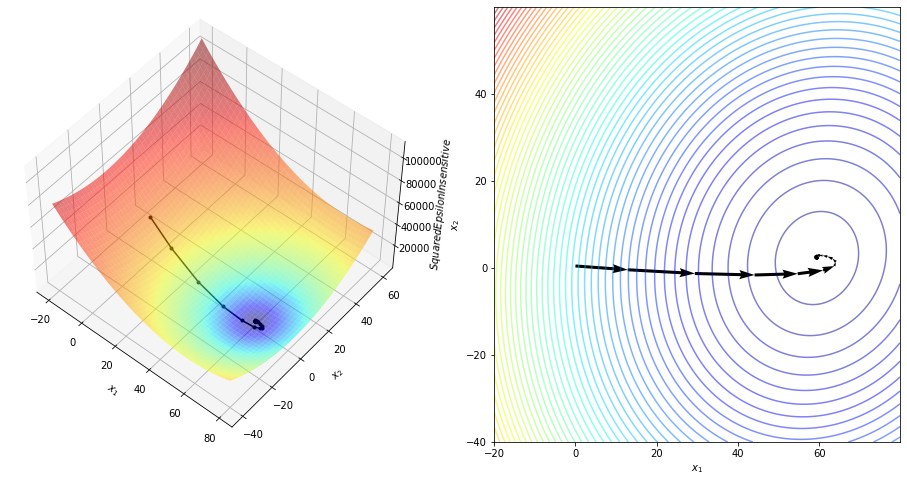

In [42]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, optimizer=StochasticGradientDescent, 
                              learning_rate=0.01, momentum=0.5, early_stopping=True, patience=5),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'momentum_type': ['none', 'standard', 'nesterov']},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-20, x_max=80, y_min=-40, y_max=60)
plt.savefig('./tex/img/svr_squared_eps_loss.png')

In [43]:
custom_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'sgd')
custom_primal_svr_squared_eps_cv_results.style.hide_index()

solver,momentum,C,epsilon,fit_time,train_r2,val_r2,n_iter,train_n_sv,val_n_sv
sgd,none,1,0.100000,0.195629,0.978126,0.973976,351,66,32
sgd,standard,1,0.100000,0.104086,0.978130,0.973982,179,66,32
sgd,nesterov,1,0.100000,0.104320,0.978130,0.973982,182,66,32
sgd,none,1,0.200000,0.200803,0.978125,0.973974,348,66,32
sgd,standard,1,0.200000,0.108426,0.978129,0.973980,177,66,32
sgd,nesterov,1,0.200000,0.105084,0.978129,0.973980,181,66,32
sgd,none,1,0.300000,0.174313,0.978124,0.973972,345,66,32
sgd,standard,1,0.300000,0.090863,0.978129,0.973977,174,66,32
sgd,nesterov,1,0.300000,0.095276,0.978129,0.973977,178,66,32
sgd,none,10,0.100000,0.025562,0.978184,0.973958,47,66,33


In [44]:
X, y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)

grid = GridSearchCV(SkLinearSVR(loss='squared_epsilon_insensitive'),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [45]:
liblinear_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svr_squared_eps_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svr_squared_eps_cv_results.style.hide_index()

solver,momentum,C,epsilon,fit_time,train_r2,val_r2,n_iter,train_n_sv,val_n_sv
liblinear,-,1,0.100000,0.000824,0.978134,0.973998,83,67,32
liblinear,-,1,0.200000,0.000822,0.978133,0.974008,87,66,32
liblinear,-,1,0.300000,0.000733,0.978130,0.974013,86,66,32
liblinear,-,10,0.100000,0.002591,0.978183,0.973965,774,66,33
liblinear,-,10,0.200000,0.002662,0.978183,0.973968,775,66,33
liblinear,-,10,0.300000,0.002766,0.978183,0.973982,754,66,32
liblinear,-,100,0.100000,0.003617,0.977810,0.974351,1000,67,32
liblinear,-,100,0.200000,0.003612,0.978173,0.973883,1000,66,33
liblinear,-,100,0.300000,0.003617,0.977908,0.974973,1000,66,32


In [46]:
primal_svr_squared_eps_cv_results = custom_primal_svr_squared_eps_cv_results.append(liblinear_primal_svr_squared_eps_cv_results, ignore_index=True)
primal_svr_squared_eps_cv_results.sort_values(['epsilon', 'C', 'solver'], inplace=True)
primal_svr_squared_eps_cv_results.to_latex('./tex/experiments/primal_svr_squared_eps.tex', index=False)
primal_svr_squared_eps_cv_results.style.hide_index()

solver,momentum,C,epsilon,fit_time,train_r2,val_r2,n_iter,train_n_sv,val_n_sv
liblinear,-,1,0.100000,0.000824,0.978134,0.973998,83,67,32
sgd,none,1,0.100000,0.195629,0.978126,0.973976,351,66,32
sgd,standard,1,0.100000,0.104086,0.978130,0.973982,179,66,32
sgd,nesterov,1,0.100000,0.104320,0.978130,0.973982,182,66,32
liblinear,-,10,0.100000,0.002591,0.978183,0.973965,774,66,33
sgd,none,10,0.100000,0.025562,0.978184,0.973958,47,66,33
sgd,standard,10,0.100000,0.013823,0.977869,0.975114,24,65,33
sgd,nesterov,10,0.100000,0.015189,0.978184,0.973958,25,66,33
liblinear,-,100,0.100000,0.003617,0.977810,0.974351,1000,67,32
sgd,none,100,0.100000,0.003544,-18.792762,-18.629559,5,67,33
